# Chargement des librairies

In [1]:
from sklearn.datasets import load_svmlight_file
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_svmlight_file
from sklearn.svm import SVC, LinearSVC
from time import time
from sklearn.metrics.pairwise import rbf_kernel
from scipy.sparse.linalg import svds
from scipy.linalg import svd
from scipy.sparse import csc_matrix
from numpy.linalg import multi_dot
from numpy.linalg import norm
from math import pi
from scipy import linalg
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy import linalg
            

# 1. Chargement des données

In [2]:
X, y = load_svmlight_file('ijcnn1')

In [3]:
X = pd.DataFrame(X.todense())
X.shape

(49990, 22)

On a bien 22 features et 49990 enregistrements.

# 2. Normalisation des données

In [4]:
scaler = StandardScaler(with_mean=False)
X_Scaled = scaler.fit_transform(X)

# 3. Construction des échantillons d’apprentissage 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_Scaled, y, test_size=0.6,random_state=42)


In [6]:
n1, p = X_train.shape
n2 = X_test.shape[0]

print("Taille des données d’apprentissag:", n1)
print("Taille des données de test:", n2)
print("Features:", p)

Taille des données d’apprentissag: 19996
Taille des données de test: 29994
Features: 22


- On a déterminé la proportion des données attribuées à l'ensemble de test par rapport à l'ensemble total de données disponibles à 60% donc on aura bien presque 20000 de données d’apprentissage et 29990 de données de test.

- La différence entre ça et les valeurs qu'on a utulisé en pratique réside dans la répartition des données entre l'ensemble de test et l'ensemble d'apprentissage. Une valeur plus grande pour test_size signifie que vous réservez une plus grande proportion de données pour l'ensemble de test, réduisant ainsi la quantité de données disponibles pour l'apprentissage.

# 4. Construction du SVM linéaire (sans noyau)

In [7]:
# Train linéaire
t0 = time()
svm_lin = LinearSVC(dual=False)
svm_lin.fit(X_train, y_train)
print("Le Temps d'apprentissage du SVM linéaire est de %fs" % (time() - t0))

Le Temps d'apprentissage du SVM linéaire est de 0.042376s


In [8]:
# Test linéaire
t1 = time()
timing_linear = time() - t1
y_pred = svm_lin.predict(X_test)
print("Le Temps de test du SVM linéaire est de %fs" % (time() - t1))

Le Temps de test du SVM linéaire est de 0.005186s


In [9]:
# Accuracy linéaire
accuracy_linear = accuracy_score(y_pred, y_test)
print("Le score de prédiction linéaire est de: %f" % accuracy_linear)

Le score de prédiction linéaire est de: 0.922118


- On remarque que le temps d'exécution du SVM linéaire est assez rapide, en ce qui concerne la précision, le SVM linéaire fonctionne bien mais d'autres méthodes auront potentiellement des meilleures résultats

# 4. Construction du SVM non linéaire (avec noyau)

In [10]:
# Train RBF
t0 = time()
clf_rbf = SVC(kernel='rbf')
clf_rbf.fit(X_train, y_train)
print("Le Temps d'apprentissage du SVM non linéaire (RBF) est de %fs" % (time() - t0))

Le Temps d'apprentissage du SVM non linéaire (RBF) est de 3.084792s


In [11]:
# Test RBF
t1 = time()
y_pred = clf_rbf.predict(X_test)
timing_kernel = time() - t1
print("Le temps de test du SVM non linéaire (RBF) est de %fs" % (time() - t1))

Le temps de test du SVM non linéaire (RBF) est de 4.203852s


In [12]:
# Accuracy RBF
accuracy_rbf = accuracy_score(y_pred, y_test)
print("Le score de prédiction du SVM non linéaire (RBF) est de %f" % accuracy_rbf)

Le score de prédiction du SVM non linéaire (RBF) est de 0.973828


# 4. Comparaison des résultats

- On remarque que le score de prédiction en utilisant le RBF est plus élevé que le SVM linéaire, en effet le RBF peut capturer des relations non linéaires entre les données, grâce à l'utilisation d'une fonction de base radiale permettant une projection de ces données dans un espace de dimension supérieure où elles sont plus facilement séparables.

- Par contre on a un temps d'exécution potentiellement plus long dû à cette projection (dans un espace de dimension supérieure) qui est plus gourmande en matière de calcul, ce qui peut rendre l'apprentissage plus lent.

# 5. Random Kernel Features

In [13]:
def random_Kernel_features(X_train, X_test, gamma, c):
    rng = np.random.RandomState(seed=42)  # Initialisation d'un générateur de nombres aléatoires avec une graine (seed = 42)
    n, p = X_train.shape  # Nombre de données et features dans X_train

    # Génération de la matrice W et le vecteur b
    W = np.random.normal(0, np.sqrt(2 * gamma), (p, c))  # Matrice W de dimensions (p, c)
    b = np.random.uniform(0, 2 * np.pi, (1, c))  # Vecteur b de dimensions (1, c)

    # Transformation des données d'entraînement et de test en utilisant la matrice W et le vecteur b générés
    X_new_train = np.sqrt(2 / c) * np.cos(np.dot(X_train, W) + b)  # Nouvelles caractéristiques pour X_train
    X_new_test = np.sqrt(2 / c) * np.cos(np.dot(X_test, W) + b)  # Nouvelles caractéristiques pour X_test
    
    return X_new_train, X_new_test  # Retourne les ensembles de données transformés


In [14]:
n, p = X_train.shape
gamma = 1. / p

In [15]:
Z_train, Z_test = random_Kernel_features(X_train, X_test, gamma, c=300)

In [16]:
t0 = time()
svm_lin = LinearSVC(dual=False)
svm_lin.fit(Z_train, y_train)
print("Le Temps d'apprentissage du SVM linéaire avec l'algorithme Random Kernel Features est de %fs" % (time() - t0))

Le Temps d'apprentissage du SVM linéaire avec l'algorithme Random Kernel Features est de 2.564520s


In [17]:
t1 = time()
accuracy = svm_lin.score(Z_test, y_test)
print("done in %0.4fs" % (time() - t1))
print("Le score de prédiction du SVM linéaire avec l'algorithme Random Kernel Features est de %fs" % accuracy)

done in 0.0177s
Le score de prédiction du SVM linéaire avec l'algorithme Random Kernel Features est de 0.959792s


# Comparaison et Commentaires sur les résultats 

- On remarque que le score de prédiction du SVM linéaire avec l'algorithle Random Kernel Features se rapproche du score de prédiction RBF et mieux que le score obtenue avec le SVM linéaire.

- Le temps d'apprentissage du SVM linéaire avec l'algorithle Random Kernel Features est légèrement petit que celui de RBF et plus grand que celui du SVM linéaire.


- L'idée principale derrière cette méthode est de projeter les données d'entrée dans un espace de dimension supérieure (comme celui du RBF) de manière approximative, en évitant les calculs coûteux associés à la transformation directe dans cet espace.

# 6. Approximation de Nyström

In [18]:
def nystrom(X_train, X_test, gamma, c, k):
    rng = np.random.RandomState(seed=44)  # Initialisation d'un générateur de nombres aléatoires avec une graine (seed = 44)
    n = X_train.shape[0]  # Nombre d'enregistrements dans X_train
    idx = rng.choice(n, c)  # Sélection aléatoire de c indices à partir de l'ensemble d'entraînement

    # Extraction du sous-ensemble d'entraînement basé sur les indices choisis
    X_train_idx = X_train[idx, :]

    # Calcul de la matrice de noyau RBF pour le sous-ensemble d'entraînement
    W = rbf_kernel(X_train_idx, X_train_idx, gamma=gamma)

    # Décomposition en valeurs singulières (SVD) de la matrice W
    u, s, vt = linalg.svd(W, full_matrices=False)
    u = u[:, :k]  # Extraction des k premières colonnes de u
    s = s[:k]  # Extraction des k premières valeurs singulières
    vt = vt[:k, :]  # Extraction des k premières lignes de vt

    # Construction de la matrice M 
    M = np.dot(u, np.diag(1 / np.sqrt(s)))

    # Calcul de C_train et c_test
    C_train = rbf_kernel(X_train, X_train_idx, gamma=gamma)
    C_test = rbf_kernel(X_test, X_train_idx, gamma=gamma)

    # Transformation des ensembles de données d'entraînement et de test
    X_new_train = np.dot(C_train, M)
    X_new_test = np.dot(C_test, M)

    return X_new_train, X_new_test  # Retourne les ensembles de données transformés


In [19]:
Z_train, Z_test = nystrom(X_train, X_test, gamma, c=500, k=300)


In [20]:
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("Le temps d'apprentissage du SVM linéaire avec l'approximation Nystrom est de %fs" % (time() - t0))

Le temps d'apprentissage du SVM linéaire avec l'approximation Nystrom est de 2.133599s


In [21]:
t1 = time()
accuracy = clf.score(Z_test, y_test)
print("Le score de prédiction du SVM linéaire avec l'approximation Nystrom est de %f" % accuracy)

Le score de prédiction du SVM linéaire avec l'approximation Nystrom est de 0.967393


# Comparaison et Commentaires sur les résultats 

- On remarque selon les résultats que le score obtenu se rapproche de celui à Random Kernel Features et RBF, mais Meilleure que SVM linéaire.

- Le temps d'apprentissage est pareil que Random Kernel Features plus élevé que SVM linéaire, le RBF reste toujours l'algorithme le plus gourmand en matière du temps.

- L'algorithme de Nyström est une méthode d'approximation qui réduit le coût de calcul en utilisant un sous-ensemble de données pour estimer une matrice de noyau complète. Cela rend le processus d'entraînement des modèles plus rapide tout en préservant une bonne performance.

# 7. Synthèse des résultats

In [24]:
ranks = np.arange(20, 600, 50)
n_ranks = len(ranks)

# Initialisation des tableaux pour stocker les temps d'exécution et les précisions pour chaque valeur de c pour chaque méthode

time_linear = np.zeros(n_ranks)
time_rbf = np.zeros(n_ranks)
time_rkf = np.zeros(n_ranks)
time_nystrom = np.zeros(n_ranks)

accuracy_linear = np.zeros(n_ranks)
accuracy_rbf = np.zeros(n_ranks)
accuracy_nystrom = np.zeros(n_ranks)
accuracy_rkf = np.zeros(n_ranks)


print("Apprentissage des SVM pour différentes valeurs de c pour les différentes méthodes...")

for i, c in enumerate(ranks):

    print(i, c)
     ## SVM Linéaire
    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(X_train, y_train)
    time_linear[i] = time() - t0
    accuracy_linear[i] = clf.score(X_test, y_test)
    
    ## RBF
    t0 = time()
    clf = SVC(kernel='rbf')
    clf.fit(X_train, y_train)
    time_rbf[i] = time() - t0
    accuracy_rbf[i] = clf.score(X_test, y_test)
    
    ## Random Kernel Feature
    Z_rkf_train, Z_rkf_test = random_Kernel_features(X_train, X_test, gamma, c=c)
    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(Z_rkf_train, y_train)
    time_rkf[i] = time() - t0
    accuracy_rkf[i] = clf.score(Z_rkf_test, y_test)

    ## Nystorm
    Z_Nystorm_train, Z_Nystorm_test = nystrom(X_train, X_test, gamma, c=c, k=c-10)

    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(Z_Nystorm_train, y_train)
    time_nystrom[i] = time() - t0
    accuracy_nystrom[i] = clf.score(Z_Nystorm_test, y_test)

Apprentissage des SVM pour différentes valeurs de c pour les différentes méthodes...
0 20
1 70
2 120
3 170
4 220
5 270
6 320
7 370
8 420
9 470
10 520
11 570


# Les graphes

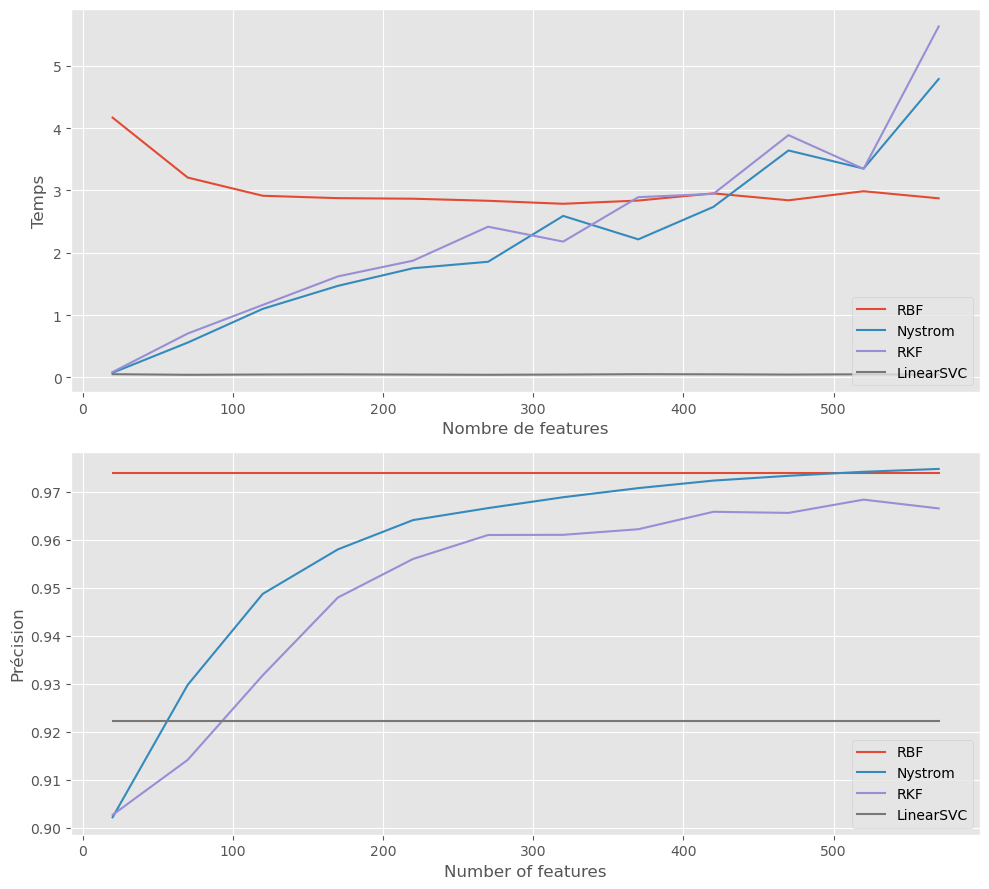

In [25]:
# Création des graphes

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,9))
ax1, ax2 = axes.ravel()

ax1.plot(ranks, time_rbf * np.ones(n_ranks), '-', label='RBF')
ax1.plot(ranks,time_nystrom, '-', label='Nystrom')
ax1.plot(ranks, time_rkf, '-', label='RKF')
ax1.plot(ranks, time_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax1.set_xlabel('Nombre de features')
ax1.set_ylabel('Temps')
ax1.legend(loc='lower right')

ax2.plot(ranks, accuracy_rbf * np.ones(n_ranks), '-', label='RBF')
ax2.plot(ranks, accuracy_nystrom, '-', label='Nystrom')
ax2.plot(ranks, accuracy_rkf, '-', label='RKF')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Précision')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Commentaires sur les résultats 

- On remarque une convergence en termes de précision RKF et Nystrom qui reste supèrieur au SVM linéaire (RBF, Nystrom et RKF sont plus performant que SVM)

- Le temps de calcul de Nystrom, RKF et SVM Llinéaire est également inférieur à celui du RBF, jusqu'à certain nombre de features l'lgorithme de Nystrom dépasse le RBF en terme de Précision et temps d'apprentissage ainsi que RKF dépasse RBF en temps d'apprentissage mais pas en précision.

- Le SVM à noyau RBF reste plus flexible et plus performant que le SVM linéaire et RKF

- Si on veut un score élevé avec un temps d'apprentissage stable, le SVM à noyau RBF est le meilleure choix meme si nystrome le dépasse à  un certains nombres de features en termes de précision cela va nous couter un temps d'apprentissage plus importants que RBF.

- On remarque aussi que SVM linéaire et RBF ne dépendent pas de C (nombre de features), par contre pour RKF et Nystrom plus C est grand plus la précision augmente  et le temps d'apprentissage aussi.